In [1]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dir = './data'

def img_show(img, figsize=4, cmap='', colorbar=False):
    plt.figure(figsize=(figsize, figsize))
    if cmap =='':
        plt.imshow(img)
    else:
        plt.imshow(img,cmap)
    if colorbar:
        plt.colorbar()
    plt.show()
    return

# 1. 임계값 분할

./data/1_threshold.png


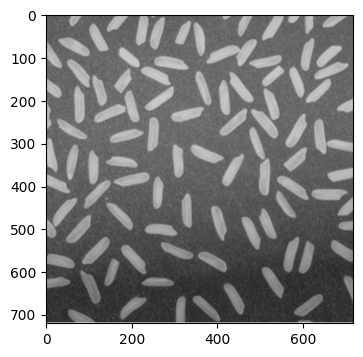

In [3]:
data_path = f'{data_dir}/1.png'
print(data_path)

img = cv2.cvtColor(cv2.imread(data_path), cv2.COLOR_BGR2RGB)
img_show(img)

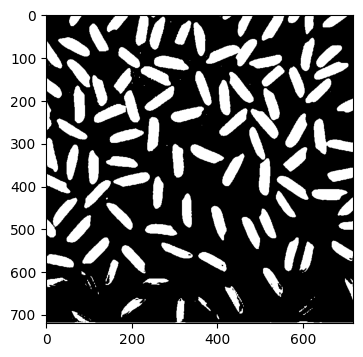

In [4]:
thresh = 127

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, thresh1 = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# cv2.threshold(src, thresh, maxval, type) → retval, dst
# Parameters:	
# src – input image로 single-channel 이미지.(grayscale 이미지)
# thresh – 임계값
# maxval – 임계값을 넘었을 때 적용할 value
# type – thresholding type

img_show(thresh1, cmap='gray')


# 2. 히스토그램 분할

./data/2_histogram.png


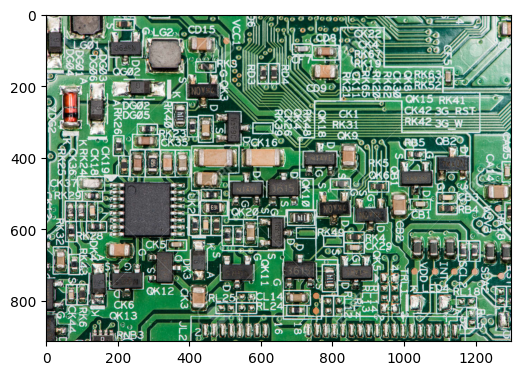

In [5]:
data_path = f'{data_dir}/2.png'
print(data_path)

img = cv2.cvtColor(cv2.imread(data_path), cv2.COLOR_BGR2RGB)
img_show(img, figsize=6)

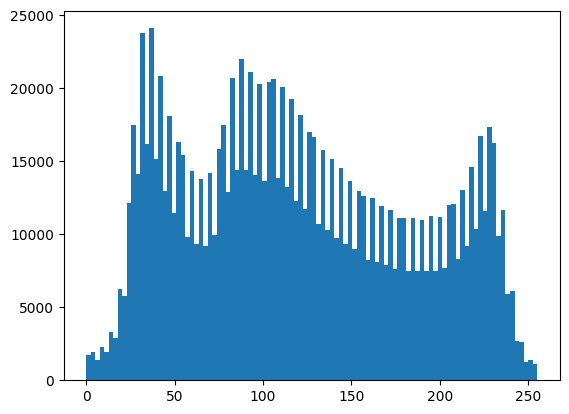

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.hist(gray.flat, bins=100, range=(0, 255)) # 2d to 1d array
plt.show()

In [7]:
def return_histo_segment(img):
    all_segments = np.zeros((img.shape[0], img.shape[1], 3))
    segm1 = (img <=55)
    segm2 = (img > 55) & (img <= 100)
    segm3 = (img > 110) & (img <= 210)
    segm4 = (img > 210)

    all_segments[segm1] = (1,0,0)
    all_segments[segm2] = (0,1,0)
    all_segments[segm3] = (0,0,1)
    all_segments[segm4] = (1,1,0)

    return all_segments

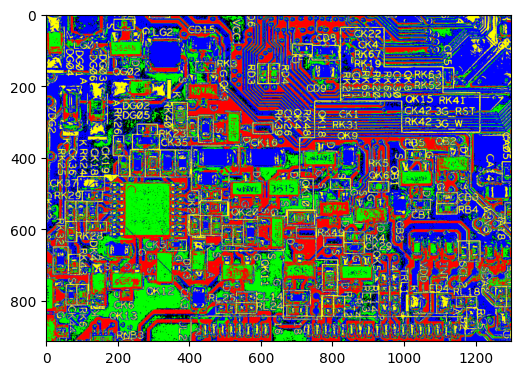

In [8]:
histo_img = return_histo_segment(gray)
img_show(histo_img, figsize=6)

# 3. 가장자리 감지

./data/3_edge.png


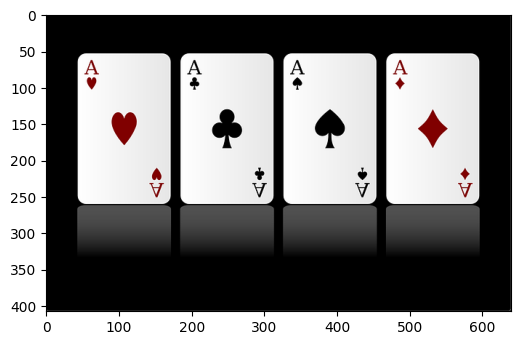

In [9]:
data_path = f'{data_dir}/3.png'
print(data_path)

img = cv2.cvtColor(cv2.imread(data_path), cv2.COLOR_BGR2RGB)
img_show(img, figsize=6)

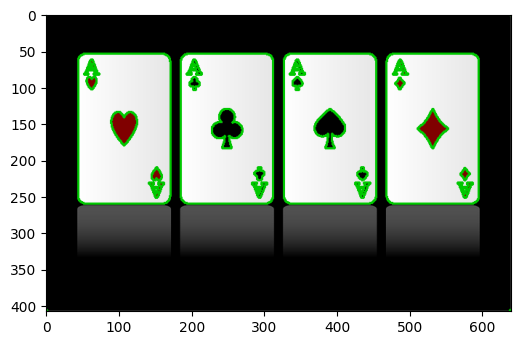

In [10]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, otsu = cv2.threshold(gray, -1, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) #오츠알고리즘으로 흑백화된 사진을 이진화 작업

contours, hierarchy = cv2.findContours(otsu, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) #이진화된 이미지에서 윤곽선 검출
#contours : 윤곽선 정보, hierarchy : 윤곽선 계층
#cv2.findContours(대상이미지, 윤곽선 찾는 모드, 윤곽선을 찾을 때 사용하는 근사치(method))

COLOR = (0,200,0)
cv2.drawContours(img, contours, -1,COLOR, 2) #윤곽선 그리기 (-1은 모든 윤곽선을 그려라)
# cv2.drawContours(대상이미지, 윤곽선 정보, 인덱스, 색, 두께)
#이진화된 이미지 otsu에서 검출한 윤곽선 정보를 target_img라는 원본 이미지의 복사본에 그림

img_show(img, figsize=6)

# 4. 워터셰드 (Wartershed)

./data/4_watershed.png


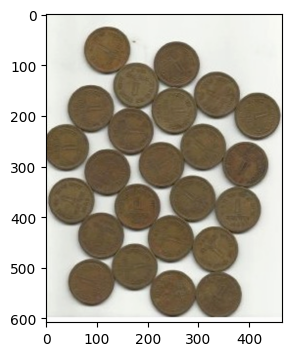

In [11]:
data_path = f'{data_dir}/4.png'
print(data_path)

img = cv2.cvtColor(cv2.imread(data_path), cv2.COLOR_BGR2RGB)
img_show(img)

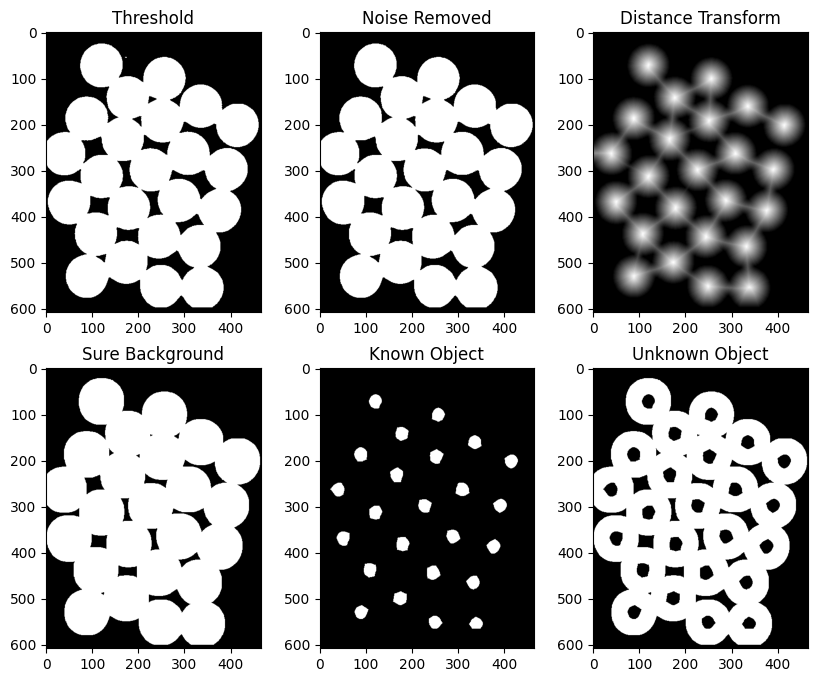

In [12]:
# 객체 이진화
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

# 노이즈 제거
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh1,cv2.MORPH_OPEN,kernel, iterations = 2)

# 배경이 확실한 영역
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# 거리 변환 적용 (각 픽셀과 가장 가까운 0인 픽셀과의 거리를 계산해서 적용)
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

# 객체가 확실한 영역 찾기
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# 객체가 확실하지 않은 영역 찾기
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

plt.figure(figsize=(10,8))
plt.subplot(231), plt.imshow(thresh1,cmap='gray')
plt.title("Threshold")
plt.subplot(232), plt.imshow(opening,cmap='gray')
plt.title("Noise Removed")
plt.subplot(233), plt.imshow(dist_transform,cmap='gray')
plt.title("Distance Transform")
plt.subplot(234), plt.imshow(sure_bg,cmap='gray')
plt.title("Sure Background")
plt.subplot(235), plt.imshow(sure_fg,cmap='gray')
plt.title("Known Object")
plt.subplot(236), plt.imshow(unknown,cmap='gray')
plt.title("Unknown Object")
plt.show()


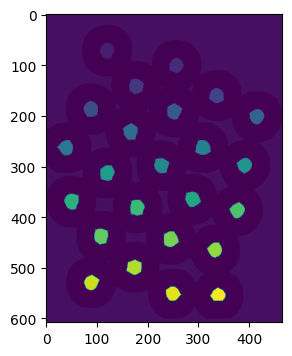

In [13]:
# Marker 라벨링
ret, markers = cv2.connectedComponents(sure_fg)

# 모든 라벨에 1을 더하여 배경이 0이 하니라 1이 되도록 한다.
# unknown 지역과 같은 값을 가지는 것을 피하기 위해
markers = markers + 1

# 이제 unknown 지역을 0으로 마크한다.
markers[unknown==255] = 0

img_show(markers)


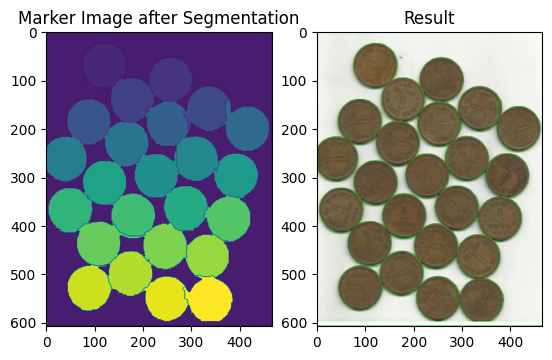

In [14]:
markers = cv2.watershed(img, markers)
img[markers == -1] = [0,200,0]
plt.subplot(121),plt.imshow(markers)
plt.title("Marker Image after Segmentation")
plt.subplot(122),plt.imshow(img)
plt.title('Result')
plt.show()


# 5. 영역 기반 분할

./data/5_region_growing.png


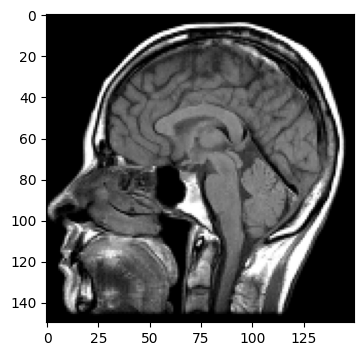

In [16]:
data_path = f'{data_dir}/5.png'
print(data_path)

resize_hw = 150
img = cv2.resize(cv2.imread(data_path, 0), (resize_hw, resize_hw))
gblur_img  = cv2.GaussianBlur(img, (3, 3), sigmaX = 0, sigmaY = 0)
img_show(img, cmap='gray')

7 (26, 90)


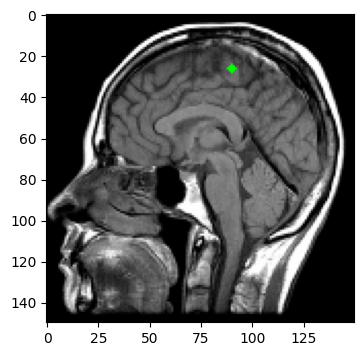

In [17]:
data_seed_path = f'{data_dir}/5_seed.png'


seed_img = cv2.resize(cv2.imread(data_seed_path, 0), (resize_hw, resize_hw))
seed_img = cv2.threshold(seed_img, 127, 255, cv2.THRESH_BINARY)[1]

seed_points = []
for y in range(seed_img.shape[0]):
    for x in range(seed_img.shape[1]):
        if seed_img[y, x] != 0:
            p = y, x
            
            seed_points.append(p)
print(len(seed_points), seed_points[0])
seed = seed_points[0]

color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
color_img = cv2.circle(color_img, (seed[1], seed[0]), 2, (0,255,0), -1)
img_show(color_img)

In [18]:
def region_growing(img, seed, threshold):
    neighbors = [(0, 1), (1, 0), (-1, 0), (0, -1)]  # 4-connectivity
    # region_threshold = 23
    region_threshold = threshold
    region_size = 1
    region_mean = float(img[seed])

    # Initialize the list of growth points
    growth_points = [seed]

    # Mark array to indicate whether a pixel has been segmented
    segmented = np.zeros_like(img, dtype=bool)

    while len(growth_points) > 0:
        new_points = []
        for point in growth_points:
            for neighbor in neighbors:
                # Calculate the position of neighboring pixel
                x_new = point[0] + neighbor[0]
                y_new = point[1] + neighbor[1]

                # Check if the neighboring pixel is outside the image boundaries
                if x_new < 0 or y_new < 0 or x_new >= img.shape[0] or y_new >= img.shape[1]:
                    continue

                # Check if the neighboring pixel has already been segmented
                if segmented[x_new, y_new]:
                    continue

                pixel_value = img[x_new, y_new]
                if abs(pixel_value - region_mean) < region_threshold:
                    segmented[x_new, y_new] = True
                    region_size += 1
                    region_mean = (region_mean * (region_size - 1) + pixel_value) / region_size
                    new_points.append((x_new, y_new))
        growth_points = new_points

    return segmented

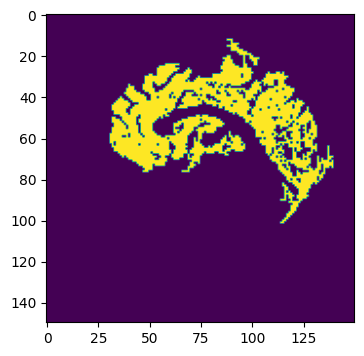

In [19]:
rg_img = region_growing(img, seed, 23)
img_show(rg_img)


# 6. 클러스터링 기반 분할

In [21]:
data = np.array([[7,1],[2,1],[4,2],[9,4],[10,5],[10,6],[11,5],[11,6],[15,3],[15,2],[16,4],[16,1]])
print(data.shape)

(12, 2)


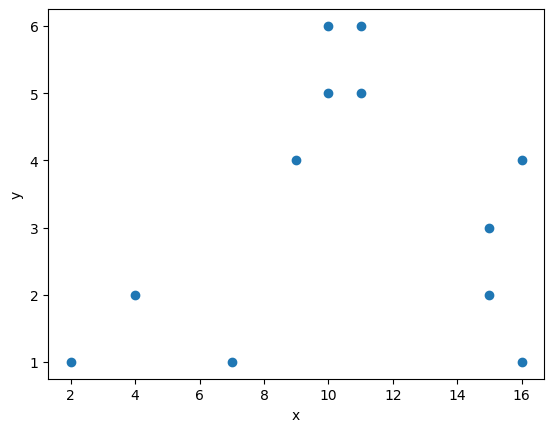

In [22]:
plt.scatter(data[:,0],data[:,1])
plt.xlabel('x'),plt.ylabel('y')
plt.show()

In [23]:
# 알고리즘을 멈출 조건 : 
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

K = 3
attempts = 10
ret,label,center = cv2.kmeans(np.float32(data),K,None,criteria,attempts,cv2.KMEANS_RANDOM_CENTERS)

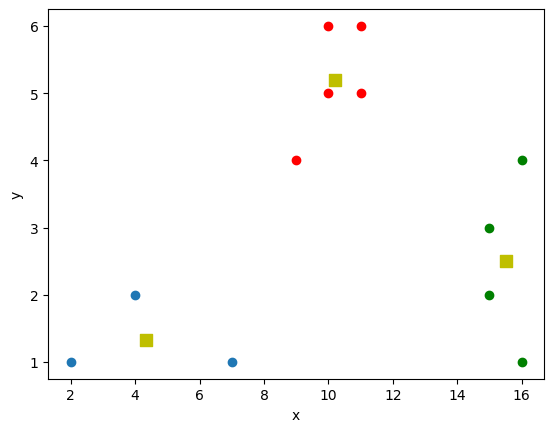

In [24]:
A = data[label.ravel()==0]
B = data[label.ravel()==1]
C = data[label.ravel()==2]

plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c = 'r')
plt.scatter(C[:,0],C[:,1],c = 'g')

plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
plt.xlabel('x'),plt.ylabel('y')
plt.show()


./data/6_clustering.png


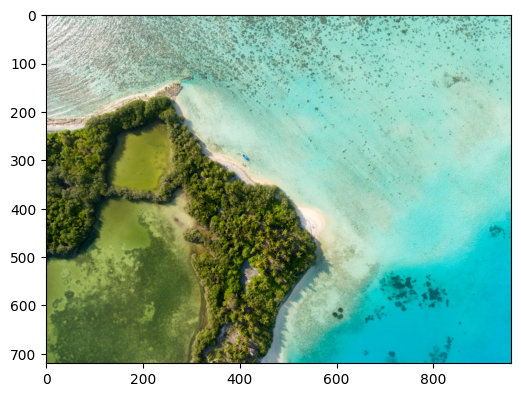

In [25]:
data_path = f'{data_dir}/6.png'
print(data_path)

img = cv2.cvtColor(cv2.imread(data_path), cv2.COLOR_BGR2RGB)
img_show(img, figsize=6)

In [26]:
class k_means:
    def __init__(self, img):
        self.img = img
        self.vectorized = self.img.reshape((-1,3))
        self.vectorized = np.float32(self.vectorized)
    
    def process(self, K):
        criteria = (cv2.TERM_CRITERIA_EPS + 
			        cv2.TERM_CRITERIA_MAX_ITER,10,1.0)

        attempts = 10 
        ret,label,center = cv2.kmeans(self.vectorized,K,None,criteria,attempts,
                                        cv2.KMEANS_PP_CENTERS)

        center = np.uint8(center)
        res = center[label.flatten()]
        self.result_image = res.reshape((self.img.shape))
              
        figure_size = 15
        plt.figure(figsize=(figure_size,figure_size))
        plt.subplot(1,2,1),plt.imshow(self.img)
        plt.title('Original Image')
        plt.subplot(1,2,2),plt.imshow(self.result_image)
        plt.title('Segmented Image when K = %i' % K)
        plt.show()


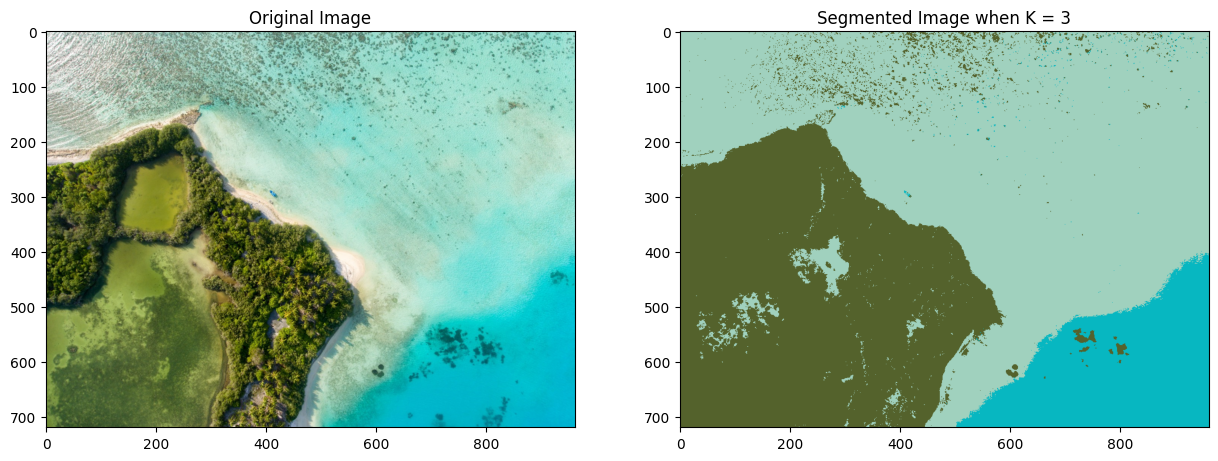

In [27]:
k_means(img).process(3)